Selected Features: ['AMT', 'DOSE', 'ADDL', 'D25BASE', 'SEASON', 'Sunlight Exposure (Hours/Day)', 'Dietary Vitamin D Intake (IU/day)']
🔹 Random Forest Accuracy: 99.81%
🔹 SVM Accuracy: 45.34%
🔹 Random Forest MAE: 0.6814, RMSE: 3.1257, R-squared: 0.9981
🔹 SVM MAE: 17.6545, RMSE: 53.2369, R-squared: 0.4534


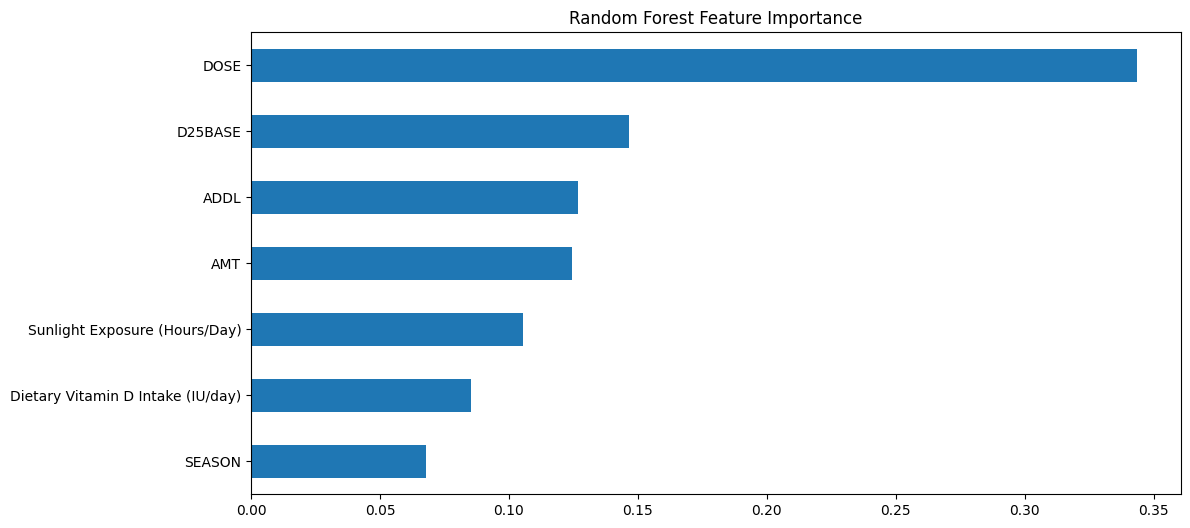

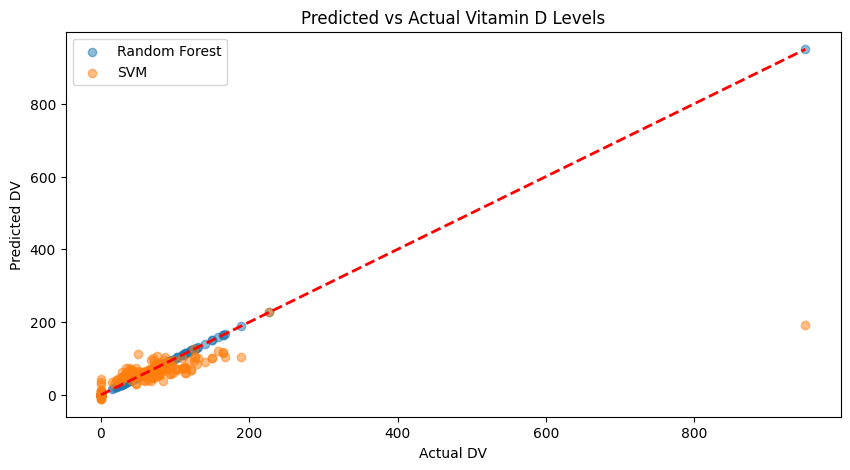

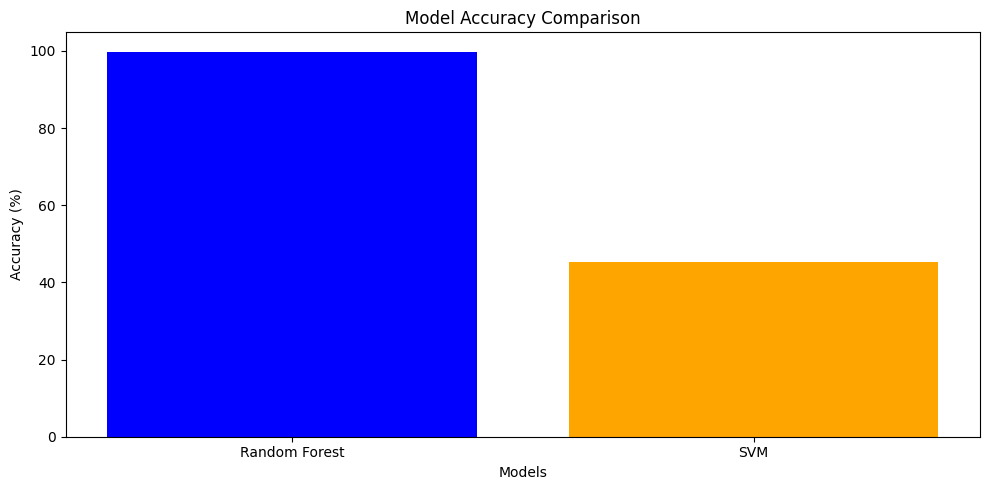

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel

# Load dataset
df = pd.read_csv("/content/datasets.csv")  # Replace with your actual dataset path

# Drop rows with missing values
df.dropna(inplace=True)

# Convert categorical variables to strings to avoid encoding issues
df = df.astype(str)

# Encoding categorical variables
categorical_cols = ["SEX", "SEASON", "CONTINENTS", "Skin Type (Fitzpatrick Scale)"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Convert all remaining columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with remaining NaN values after conversion
df.dropna(inplace=True)

# Define features (X) and target variable (y)
X = df.drop(columns=["DV", "ID", "TIME"])
y = df["DV"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature Selection using Random Forest
selector = SelectFromModel(RandomForestRegressor(n_estimators=500, random_state=42), threshold="median")
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Keep only selected feature names
selected_features = df.drop(columns=["DV", "ID", "TIME"]).columns[selector.get_support()]
print("Selected Features:", list(selected_features))

# Hyperparameter tuning for Random Forest
param_distributions = {
    'n_estimators': [500, 800, 1000, 1200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42]
}

rf_model = RandomForestRegressor()

# RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions,
    n_iter=30,  # Increased n_iter for better tuning
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=2,
    random_state=42
)

random_search_rf.fit(X_train_selected, y_train)

# Best Random Forest model
rf_best_model = random_search_rf.best_estimator_

# SVM Regressor
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svm_model.fit(X_train_selected, y_train)

# Predictions for Random Forest and SVM
y_pred_rf = rf_best_model.predict(X_test_selected)
y_pred_svm = svm_model.predict(X_test_selected)

# Evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
r2_rf = r2_score(y_test, y_pred_rf)
r2_svm = r2_score(y_test, y_pred_svm)

# Calculate accuracy percentage
rf_accuracy = r2_rf * 100
svm_accuracy = r2_svm * 100

# Accuracy and Error Display
print(f"🔹 Random Forest Accuracy: {rf_accuracy:.2f}%")
print(f"🔹 SVM Accuracy: {svm_accuracy:.2f}%")
print(f"🔹 Random Forest MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R-squared: {r2_rf:.4f}")
print(f"🔹 SVM MAE: {mae_svm:.4f}, RMSE: {rmse_svm:.4f}, R-squared: {r2_svm:.4f}")

# Feature Importance (for Random Forest)
feature_importances_rf = pd.Series(rf_best_model.feature_importances_, index=selected_features)

# Plotting Feature Importances
plt.figure(figsize=(12, 6))
feature_importances_rf.sort_values().plot(kind='barh', title='Random Forest Feature Importance')
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.5)
plt.scatter(y_test, y_pred_svm, label='SVM', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel("Actual DV")
plt.ylabel("Predicted DV")
plt.title("Predicted vs Actual Vitamin D Levels")
plt.legend()
plt.show()

# Accuracy Comparison
models = ['Random Forest', 'SVM']
accuracy_scores = [rf_accuracy, svm_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracy_scores, color=['blue', 'orange'])
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")

plt.tight_layout()
plt.show()
